In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%tensorflow_version 1.15
import tensorflow as tf

tf.enable_eager_execution()

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
!pip install git+https://github.com/google-research/data-driven-advection.git
import xarray
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations
from datadrivenpdes.pipelines import model_utils

  Cloning https://github.com/google-research/data-driven-advection.git to /tmp/pip-req-build-nke_loav
  Running command git clone -q https://github.com/google-research/data-driven-advection.git /tmp/pip-req-build-nke_loav
     |████████████████████████████████| 9.6MB 4.5MB/s 
     |████████████████████████████████| 153kB 48.1MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 2.3MB 37.8MB/s 
     |████████████████████████████████| 829kB 26.7MB/s 
  Created wheel for pde-superresolution-2d: filename=pde_superresolution_2d-0.0.0-cp37-none-any.whl size=78424 sha256=cd20431c7d8339d2fd975c0383c314e393774a859537f23fffbefd7f026a6dbc
  Stored in directory: /tmp/pip-ephem-wheel-cache-jxquhbyw/wheels/42/7c/3a/577e895896a4e3ccab7f2dd8b526342a8cbb41450417aa149f
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78545 sha256=2ee91666e1e4afe2e23e57fa52f484ceb39ae7288ee3d7c369c8b920f05ba784
  Stored in directory: /root/.cache/pip/whe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
fine_grid = grids.Grid(
    size_x=128, size_y=128, 
    step=32/256
    )

coarse_grid = grids.Grid(
    size_x=32, size_y=32, 
    step=32/32
    )

x_fine, y_fine = fine_grid.get_mesh()
x_coarse, y_coarse = coarse_grid.get_mesh()

print(np.max(x_coarse), np.min(x_coarse))

31.5 0.5


In [ ]:
def make_square(x, height=1.0, center=0.25, width=0.1):
  """
  Args:
    x: Numpy array. Shape should be (nx, 1) or (nx,)
    height: float, peak concentration
    center: float, relative center position in 0~1
    width: float, relative width in 0~0.5

  Returns:
    Numpy array, same shape as `x`
  """
  nx = x.shape[0]
  c = np.zeros_like(x)
  c[int((center-width)*nx):int((center+width)*nx)] =  height
  return c

def make_multi_square(x, height_list, width_list):
  c_list = []
  for height in height_list:
    for width in width_list:
      c_temp = make_square(x, height=height, width=width)
      c_list.append(c_temp)

  return np.array(c_list)

(10, 32, 32)


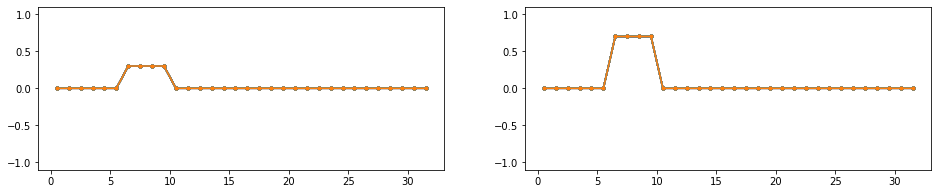

In [ ]:
height_list = np.arange(0.1, 1.1, 0.1)
width_list = np.arange(1/16, 2/16, 1/16)  # width is chosen so that coarse-graining of square wave is symmetric

c_init = make_multi_square(
  x_coarse,
  height_list = height_list,
  width_list = width_list
)

print(c_init.shape)  # (sample, x, y)

fig, axes = plt.subplots(1, 2, figsize=[16, 3])

for i, ax in enumerate(axes):
  ax.plot(x_coarse, c_init[4*i+2, :, 0], marker='.')
  ax.set_ylim(-1.1, 1.1)

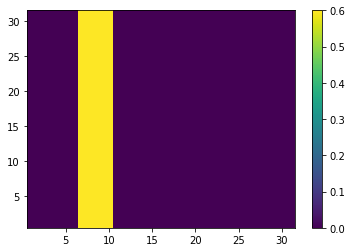

In [ ]:
plt.pcolormesh(x_coarse, y_coarse, c_init[5])
plt.colorbar()



In [ ]:
initial_state = {
    'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init.shape, np.float32)
}

for k, v in initial_state.items():
  print(k, v.shape)   # (sample, x, y)

time_steps = np.arange(0, 256+1)




concentration (10, 32, 32)
x_velocity (10, 32, 32)
y_velocity (10, 32, 32)


In [ ]:
# first-order finite difference model, very diffusive
model_test = models.FiniteDifferenceModel(
    advection_equations.UpwindAdvection(cfl_safety_factor=0.5), 
    coarse_grid,
    )
%time integrated_1st = integrate.integrate_steps(model_test, initial_state, time_steps)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 689 ms, sys: 67.7 ms, total: 757 ms
Wall time: 1.07 s


In [ ]:
model_nn = models.PseudoLinearModel(
    advection_equations.FiniteVolumeAdvection(0.5), 
    coarse_grid,
    num_time_steps=4,  # multi-step loss function
    stencil_size=3, kernel_size=(3, 1), num_layers=4, filters=32,
    constrained_accuracy_order=1, 
    learned_keys = {'concentration_edge_x', 'concentration_edge_y'},  # finite volume view, use edge concentration
    activation='relu',
)

model_nn.equation.find_base_key('concentration'), model_nn.fd_model.coefficients, len(model_nn.fd_model.stencils['concentration']),
parent = model_nn.equation.key_definitions['concentration']
((model_nn.fd_model.coefficients))

DictWrapper({'concentration_edge_y': <tf.Tensor: id=16684, shape=(2,), dtype=float32, numpy=array([0.5, 0.5], dtype=float32)>, 'x_velocity': None, 'y_velocity': None, 'concentration': None, 'concentration_edge_x': <tf.Tensor: id=16685, shape=(2,), dtype=float32, numpy=array([0.5, 0.5], dtype=float32)>})

In [ ]:
# This data-generation code is a bit involved, mostly because we use multi-step loss function.
# To produce large training data in parallel, refer to the create_training_data.py script in source code.

def reference_solution(initial_state_fine, fine_grid, coarse_grid, 
                       coarse_time_steps=256):

  # use high-order traditional scheme as reference model
  equation = advection_equations.VanLeerAdvection(cfl_safety_factor=0.5)
  key_defs = equation.key_definitions

  # reference model runs at high resolution
  model = models.FiniteDifferenceModel(equation, fine_grid)
  
  # need 8x more time steps for 8x higher resolution to satisfy CFL
  coarse_ratio = fine_grid.size_x // coarse_grid.size_x
  steps = np.arange(0, coarse_time_steps*coarse_ratio+1, coarse_ratio)

  # solve advection at high resolution
  integrated_fine = integrate.integrate_steps(model, initial_state_fine, steps)

  # regrid to coarse resolution
  integrated_coarse = tensor_ops.regrid(
      integrated_fine, key_defs, fine_grid, coarse_grid)
  
  return integrated_coarse


def make_train_data(integrated_coarse, coarse_time_steps=256, example_time_steps=4):
  # we need to re-format data so that single-step input maps to multi-step output

  # remove the last several time steps, as training input
  train_input = {k: v[:-example_time_steps] for k, v in integrated_coarse.items()}

  print('\nBefore reshape train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # merge time and sample dimension as required by model
  n_time, n_sample, n_x, n_y = train_input['concentration'].shape
  for k in train_input:
    train_input[k] = tf.reshape(train_input[k], [n_sample * n_time, n_x, n_y])

  print('\n train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # pick the shifted time series, as training output

  output_list = []
  for shift in range(1, example_time_steps+1):
    # output time series, starting from each single time step
    output_slice = integrated_coarse['concentration'][shift:coarse_time_steps - example_time_steps + shift + 1] 
    # merge time and sample dimension as required by training
    n_time, n_sample, n_x, n_y = output_slice.shape
    output_slice = tf.reshape(output_slice, [n_sample * n_time, n_x, n_y])
    output_list.append(output_slice)

  train_output = tf.stack(output_list, axis=1)  # concat along shift_time dimension, after sample dimension

  print('\n train_output shape:',  train_output.shape)  # (merged_sample, shift_time, x, y)

  # sanity check on shapes
  assert train_output.shape[0] == train_input['concentration'].shape[0]  # merged_sample
  assert train_output.shape[2] == train_input['concentration'].shape[1]  # x
  assert train_output.shape[3] == train_input['concentration'].shape[2]  # y
  assert train_output.shape[1] == example_time_steps

  return train_input, train_output

In [ ]:
# need to re-evaluate initial condition on high-resolution grid

c_init_fine = make_multi_square(
  x_fine,
  height_list = height_list,
  width_list = width_list
)

initial_state_fine = {
    'concentration': c_init_fine.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init_fine.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init_fine.shape, np.float32)
}

%time integrated_ref = reference_solution(initial_state_fine, fine_grid, coarse_grid)
train_input, train_output = make_train_data(integrated_ref)

CPU times: user 1min 13s, sys: 7.9 s, total: 1min 21s
Wall time: 50.1 s

Before reshape train_input shape:
concentration (253, 10, 32, 32)
x_velocity (253, 10, 32, 32)
y_velocity (253, 10, 32, 32)

 train_input shape:
concentration (2530, 32, 32)
x_velocity (2530, 32, 32)
y_velocity (2530, 32, 32)

 train_output shape: (2530, 4, 32, 32)


[(10, 128, 128), (10, 128, 128), (10, 128, 128)]


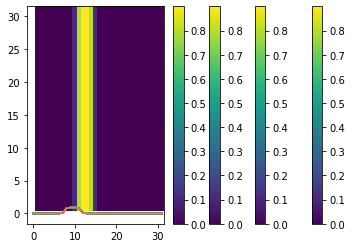

In [ ]:
print([v.shape for v in initial_state_fine.values()])


# make sure that single-step input corresponds to multi-step (advected) output

i_sample = 48  # any number between 0 and train_output.shape[0]

plt.plot(train_input['concentration'][i_sample].numpy(), label='init')
for shift in range(train_output.shape[1])[:4]:
  #plt.plot(train_output[i_sample, shift].numpy(), label=f'shift={shift+1}')
  plt.pcolormesh(x_coarse, y_coarse, train_output[i_sample,shift])
  plt.colorbar()
#plt.title(f'no. {i_sample} sample')
#plt.legend()


In [ ]:
%%time 
# same as training standard Keras model
model_nn.compile(
    optimizer='adam', loss='mae'
    )

tf.random.set_random_seed(42)
np.random.seed(42)

CPU times: user 3.02 ms, sys: 0 ns, total: 3.02 ms
Wall time: 3.03 ms


In [ ]:
history = model_nn.fit(
    train_input, train_output, epochs=120, batch_size=32, 
    verbose=1, shuffle=True
    )

Instructions for updating:
ksizes is deprecated, use sizes instead
Train on 2530 samples
Epoch 1/120
1056/2530 [===========>..................] - ETA: 33s - loss: 0.0074

KeyboardInterrupt: ignored

In [ ]:
def wrap_as_xarray(integrated):
  dr = xarray.DataArray(
      data=integrated['concentration'].numpy(),
      dims = ('time', 'sample', 'x', 'y'),
      coords = {'time': time_steps,  'x': x_coarse[0], 'y' : y_coarse[0]}
  )
  return dr

In [ ]:
%time integrated_nn = integrate.integrate_steps(model_nn, initial_state, time_steps)

CPU times: user 10.1 s, sys: 363 ms, total: 10.5 s
Wall time: 7.55 s


In [ ]:
integrated_nn['concentration'].numpy().shape

dr_nn = wrap_as_xarray(integrated_nn)
dr_nn.sizes

Frozen({'time': 257, 'sample': 10, 'x': 32, 'y': 32})

  Created wheel for animatplot: filename=animatplot-0.4.2-cp37-none-any.whl size=16509 sha256=9522504800b607956f5eab7d7949c0c7463f76e6093d7342b2bf9e65046f7197
  Stored in directory: /root/.cache/pip/wheels/0f/ff/d5/82795202b7bf774ae60cbef1b7905c1d46dbc0ec2ec2a67719
Successfully built animatplot


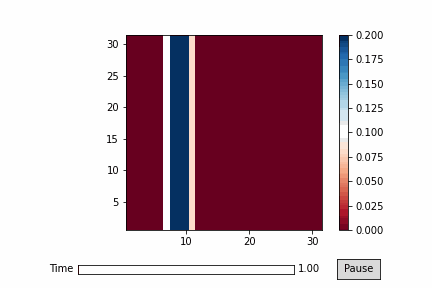

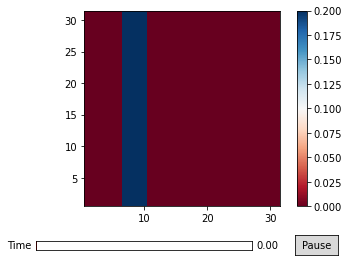

In [ ]:
!pip install animatplot
import animatplot as amp

block = amp.blocks.Pcolormesh(x_coarse, y_coarse, integrated_nn['concentration'].numpy()[:,1,:,:].squeeze(), t_axis=0, cmap='RdBu')
plt.colorbar(block.quad)
plt.gca().set_aspect('equal')

#plt.pcolormesh(x_coarse, y_coarse, integrated_nn['concentration'].numpy()[10,1,:,:])

anim = amp.Animation([block])

anim.controls()

anim.save_gif('pcolormesh')
from IPython.display import Image
Image(open('pcolormesh.gif','rb').read())


In [ ]:
ol1 = model_nn.output_layers['concentration_edge_x']

In [ ]:
ol1.kernel_size

5